<a href="https://colab.research.google.com/github/akitim/Ligand_activity_prediction_GlobalAI2022/blob/main/ligand_activity_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Импорт библиотек

In [1]:
!python -m pip install rdkit-pypi

     |████████████████████████████████| 20.6 MB 17.1 MB/s 


In [123]:
!pip install catboost

     |████████████████████████████████| 76.1 MB 51 kB/s 


In [126]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from rdkit import Chem
from rdkit.Chem.Draw import IPythonConsole

from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler

## Функции

In [100]:
def get_submission_file(clf, data):
    
    X_test = data[data['is_test']].\
        drop(['is_test', 'smiles', 'active'], axis=1)

    submission = data[data['is_test']].\
        drop(['is_test', 'active'], axis=1).copy()
    submission['Active'] = clf.predict(X_test)
    submission.columns = ['Smiles', 'Active']

    submission.to_csv('submission.csv')
    return submission

## Загружаем данные:

In [33]:
train_path = 'https://raw.githubusercontent.com/akitim/datasets/main/ligand_activity_prediction/train.csv'
test_path = 'https://raw.githubusercontent.com/akitim/datasets/main/ligand_activity_prediction/test.csv'

train = pd.read_csv(train_path)
# train = pd.read_csv('/content/train.csv')
test = pd.read_csv(test_path)
# test = pd.read_csv('/content/test.csv')

train.sample(5)

,Unnamed: 0,Smiles,Active
3518,3518,C(=C/c1ccccc1)\CN1CCN(C(c2ccccc2)c2ccccc2)CC1,False
1408,1408,CN(C)c1ccc(-c2nc3ccccc3s2)cc1,False
1710,1710,CCCC(=O)N1CCCN(c2nc(N)c3cc(OC)c(OC)cc3n2)CC1.Cl,False
722,722,CCNC(=O)[C@H]1O[C@@H](n2cnc3c(N)nc(NCCc4ccc(CC...,False
3536,3536,O=C(CCCCCCCn1cc(-c2cccnc2)nn1)Nc1ccccc1-c1ccccc1,False


In [34]:
train = train.loc[:, ['Smiles', 'Active']]
train.columns = ['smiles', 'active']
train['is_test'] = False
# train['active'] = train['active'].astype('int32')

test = test.loc[:, ['Smiles']]
test['active'] = np.nan
test.columns = ['smiles', 'active']
test['is_test'] = True

data = pd.concat([train, test]).reset_index(drop=True)

In [6]:
data.sample(5)

,smiles,active,is_test
2508,O=c1ccn([C@@H]2O[C@H](COP(=O)(O)OP(=O)(O)OP(=O...,False,0
4300,O=C1c2c(O)ccc(O)c2C(=O)c2c(NCCNCCO)ccc(NCCNCCO...,False,0
4967,CC(C)Cn1cnc2c1c(=O)n(C)c(=O)n2C,False,0
790,COc1cc([C@H]2Oc3ccc([C@H]4Oc5cc(O)cc(O)c5C(=O)...,False,0
2426,CN(C)C(=O)Oc1ccc[n+](C)c1,False,0


In [7]:
train.shape, test.shape

((5557, 3), (1614, 3))

In [8]:
active_ind = train.groupby('active').groups[1]
not_active_ind = train.groupby('active').groups[0]
print(f"Active: {active_ind.size}\n\
Not active: {not_active_ind.size}")

Active: 206
Not active: 5351


## Визуализируем активные молекулы:

In [9]:
# smiles_active = train.iloc[active_ind, :]['smiles'].values
# fig, axs = plt.subplots(25, 2, figsize=(10, 100))
# axs = axs.ravel()

# for i, smpl in enumerate(smiles_active[50:100]):
#     mol = Chem.MolFromSmiles(smpl)
#     im = Chem.Draw.MolToImage(mol)
#     print(f'{i}) {smpl}')
#     # plt.figure(figsize = (3, 3))
#     # axs(i) = plt.axes(frameon=True)
#     axs[i].imshow(im)
#     axs[i].axis('off');

## Модель 0 (random baseline)

In [10]:
# submission = test.copy()
# submission['Active'] = (np.random.rand(test.shape[0]) <= 206 / 5351)
# #(np.random.rand(test.shape[0]) <= 206 / 5351) #.astype('int32')
# test.loc[test['Active'], 'Active'].count() / test.shape[0]
# submission.to_csv('submission.csv')


## Генерация новых признаков

In [35]:
from rdkit.Chem.Descriptors import MolWt

def num_of_(df, atom) -> pd.DataFrame:
    df_ = df.copy()
    df_[atom] = df_['smiles'].apply(lambda smpl: smpl.count(atom))
    return df_    

data['MW'] = data['smiles'].apply(lambda x:
                                  np.round(MolWt(Chem.MolFromSmiles(x)), 1))

atoms = ['C', 'c', 'O', 'o', 'N', 'N+', 'n', 'P', 'p',
         'S', 's', 'Cl', 'Br', 'F', '(']
for a in atoms:
    data = num_of_(data, a)

In [97]:
RND_SEED = 42

# стандартизируем ВСЕ данные, опираясь на параметры тренировочной выборки
# меняем data!!!

std_scaler = StandardScaler()
std_scaler.fit(data[~data['is_test']]
               .drop(['is_test', 'smiles', 'active'], axis=1))

X_total = data.drop(['is_test', 'smiles', 'active'], axis=1)
X_total.loc[:,:] = std_scaler.transform(X_total)
data.loc[:, ~data.columns.isin(['is_test', 'smiles', 'active'])] = X_total

# разбиваем датасет на тренировку и валидацию
X = data[~data['is_test']].drop(['is_test', 'smiles', 'active'], axis=1)
y = data.loc[~data['is_test'], 'active']

X_train, X_val, y_train, y_val = train_test_split(X, y,
                                                  test_size=0.2,
                                                  random_state=RND_SEED)

## Логрегрессия и случайный лес

In [111]:
RND_SEED = 42

lrgr = LogisticRegression(random_state=RND_SEED,
                          n_jobs=-1, 
                          class_weight='balanced',
                          max_iter=500)
lrgr.fit(X_train, y_train)
y_pred_lrgr = lrgr.predict(X_val)

# y_pred_lrgr = ~y_pred_lrgr.astype(bool)
f1_lrgr = f1_score(y_val, y_pred_lrgr)

rfc = RandomForestClassifier(n_estimators=1000, criterion="entropy",
                             max_depth=60, min_samples_leaf=4,
                             min_samples_split=2,
                             max_features=None, bootstrap=True,
                             n_jobs=-1, random_state=RND_SEED,
                             class_weight='balanced')
rfc.fit(X_train, y_train)
y_pred_rfc = rfc.predict(X_val)
# y_pred_rfc = ~y_pred_rfc.astype(bool)

f1_rfc = f1_score(y_val, y_pred_rfc)
f1_lrgr, f1_rfc

(0.0990990990990991, 0.1111111111111111)

## Submission LogRegression

In [ ]:
submission = test.drop(['is_test', 'active'], axis=1).copy()

X_test = data[data['is_test'] == 1].drop(['is_test', 'smiles', 'active'], axis=1)
y_pred_test = lrgr.predict(X_test)

submission['Active'] = y_pred_test
submission.columns = ['Smiles', 'Active']
submission

# #(np.random.rand(test.shape[0]) <= 206 / 5351) #.astype('int32')
# test.loc[test['Active'], 'Active'].count() / test.shape[0]
# submission.to_csv('submission.csv')

,Smiles,Active
0,COC(=O)Nc1ccc(-c2nc(N3CCOCC3)c3cnn(C4CCN(Cc5cc...,False
1,O=Cc1cn(Cc2ccc(Cl)cc2)c2ccccc12,True
2,NC(CO)C(=O)NNCc1ccc(O)c(O)c1O,False
3,Nc1nc(=O)n([C@H]2C[C@H](O)[C@@H](CO)O2)cc1Cl,False
4,Nc1ccc(C(=O)Nc2cccc(-c3nc(N4CCOCC4)c4oc5ncccc5...,True
...,...,...
1609,NS(=O)(=O)c1cc2c(cc1Cl)NC(C1CC3C=CC1C3)NS2(=O)=O,True
1610,Cc1cccc(Nc2ccncc2S(=O)(=O)NC(=O)NC(C)C)c1,True
1611,CCCC(=O)O[C@]1(C(=O)CO)CC[C@H]2[C@@H]3CCC4=CC(...,False
1612,CN(C)c1cccc(Oc2cnc(Nc3cccc(O)c3)nc2)c1,True


## Логрегрессия с кросс-валидацией

In [112]:
lrgr_cv = LogisticRegressionCV(Cs=10,
                               cv=5, # cv=int - Stratified Cross-Validation w/10 folds
                               scoring='f1',
                               solver='liblinear',
                               penalty='l2',
                               max_iter=500,
                               class_weight='balanced',
                               random_state=RND_SEED, 
                            #    l1_ratios=np.arange(0, 1.2, 0.3)
)
lrgr_cv.fit(X, y)


LogisticRegressionCV(class_weight='balanced', cv=5, max_iter=500,
                     random_state=42, scoring='f1', solver='liblinear')

Max F1 = 0.11204538764574293


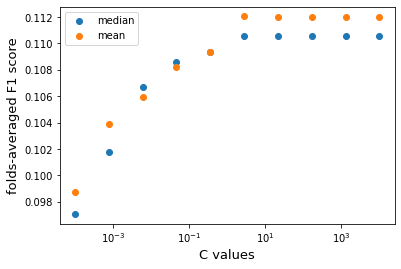

In [122]:
lrgr_cv.scores_[True].shape
lrgr_cv.get_params()

# print(lrgr_cv.Cs_)
# print(lrgr_cv.scores_[True].mean(axis=0))

plt.scatter(lrgr_cv.Cs_, np.median(lrgr_cv.scores_[True], axis=0));
plt.scatter(lrgr_cv.Cs_, np.mean(lrgr_cv.scores_[True], axis=0));
plt.xlabel('C values', fontsize=13)
plt.ylabel('folds-averaged F1 score', fontsize=13)
plt.xscale('log');
plt.legend(['median', 'mean'], loc='best');

print( f'Max F1 = {np.mean(lrgr_cv.scores_[True], axis=0).max()}')

##Catboost

In [138]:
from catboost import CatBoostClassifier, Pool, FeaturesData

# разбиваем датасет на тренировку и валидацию
X_cb = data[~data['is_test']].drop(['is_test', 'active'], axis=1)
y_cb = data.loc[~data['is_test'], 'active']

X_cb_train, X_cb_val, y_cb_train, y_cb_val = train_test_split(
    X_cb, y_cb, test_size=0.2, random_state=RND_SEED
)

X_cb_train_fd= Pool(FeaturesData(
    num_feature_data = X_cb_train['MW'].values.reshape(-1, 1).astype('np.float32'),
    cat_feature_data = X_cb_train.drop(['MW', 'smiles'], axis=1).values,
    num_feature_names = 'MW',
    cat_feature_names = X_cb_train.drop(['MW', 'smiles'], axis=1).values
))

X_cb_val_pool = Pool(FeaturesData(
    num_feature_data = X_cb_val['MW'].values.reshape(-1, 1).astype('np.float32'),
    cat_feature_data = X_cb_val.drop(['MW', 'smiles'], axis=1).values,
    num_feature_names = 'MW',
    cat_feature_names = X_cb_val.drop(['MW', 'smiles'], axis=1).values
))

# X_cb_train_pool = 

TypeError: ignored

In [136]:
X_cb_val['MW'].values.reshape(-1, 1)

array([[ 0.46464058],
       [-0.48051699],
       [ 0.22245474],
       ...,
       [ 0.28228212],
       [ 1.20097758],
       [-0.74628863]])

In [125]:
X_cb = data[~data['is_test']].drop(['is_test', 'active'], axis=1)


str

---
---
---
ИДЕИ
---
---

CN(Cc1ccccc1)C(=O)[C@H](Cc1ccc2ccccc2c1)NC(=O)[C@@H]1CCCN1C(=O)Nc1ccccc1[N+](=O)[O-]


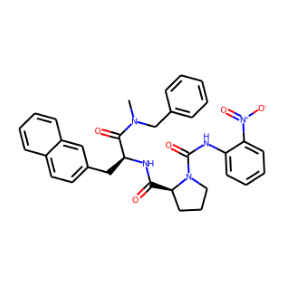

In [ ]:
smpl = train['smiles'][134]
mol = Chem.MolFromSmiles(smpl)
im = Chem.Draw.MolToImage(mol)
print(f'{smpl}')
plt.figure(figsize = (5, 5))
axs = plt.axes(frameon=True)
axs.imshow(im)
axs.axis('off');

### Оцениваем эффект на F1-score от замены y_pred на ~y_pred

In [79]:
# from sklearn.metrics import f1_score
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt

# n_sample = 1600
# y_true = np.random.rand(n_sample) >= 0.5
# y_pred = y_true.copy()

# f1 = []
# f1_not = []

# for i in range(3000):
#     ind = np.random.randint(n_sample)
#     if y_pred[ind] == y_true[ind]:
#         y_pred[ind] = not(y_pred[ind])

#     f1 += [f1_score(y_true, y_pred)]
#     f1_not += [f1_score(y_true, ~y_pred)]
   
# # plt.hist(y_true.astype(int));

In [ ]:
# plt.figure(figsize=(10, 10))
# plt.scatter(f1, f1_not);
# plt.xlabel('False F1', fontsize=15);
# plt.ylabel('True F1', fontsize=15);
# plt.plot([0, 1], [1, 0],);

In [3]:
# mol = Chem.MolFromSmiles('CNNc1ccc(C(O)c2ccccc2)c(O)c1')
# mol = Chem.MolFromSmiles('Nc1nc(O)c2c(n1)NCC(CNc1ccc(C(=O)N[C@@H](CCC(=O)[O-])C(=O)[O-])cc1)N2C=O.[Ca+2]')
# im = Chem.Draw.MolToImage(mol)

# plt.figure(figsize = (10, 10))
# ax = plt.axes(frameon=True)
# ax.imshow(im)
# ax.axis('off');